# **Node classification with GCN**



## **Installation**

In [1]:
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 435 kB 7.7 MB/s 
     |████████████████████████████████| 500 kB 58.6 MB/s 
     |████████████████████████████████| 120 kB 66.9 MB/s 
     |████████████████████████████████| 1.6 MB 15.8 MB/s 
     |████████████████████████████████| 82 kB 691 kB/s 
     |████████████████████████████████| 41 kB 520 kB/s 


In [2]:
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

## **Data Preparation**


In [4]:
dataset = sg.datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [5]:
#info method can help us verify that our loaded graph matches the description

print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


We aim to train a graph-ML model that will predict the "subject" attribute on the nodes. These subjects are one of 7 categories, with some categories more common than others.

In [6]:
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


### **Splitting the data**

In [7]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

In [8]:
train_subjects.value_counts().to_frame()

,subject
Neural_Networks,42
Probabilistic_Methods,22
Genetic_Algorithms,22
Theory,18
Case_Based,16
Reinforcement_Learning,11
Rule_Learning,9


The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support. However, we will ignore the class imbalance in this example, for simplicity.

### **Converting to numeric arrays**

In [9]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [10]:
generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


In [11]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [12]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

To create a Keras model we now expose the input and output tensors of the GCN model for node prediction, via the `GCN.in_out_tensors` method:

In [13]:
x_inp, x_out = gcn.in_out_tensors()

x_out

<KerasTensor: shape=(1, None, 16) dtype=float32 (created by layer 'gather_indices')>

In [15]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

## **Training and evaluating**

Now let's create the actual Keras model with the input tensors `x_inp` and output tensors being the predictions `predictions` from the final dense layer. Our task is a categorical prediction task, so a categorical cross-entropy loss function is appropriate. Even though we're doing graph ML with StellarGraph, we're still working with conventional Keras prediction values, so we can use the loss function from Keras directly.

In [16]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


As we're training the model, we'll want to also keep track of its generalisation performance on the validation set, which means creating another data generator, using our `FullBatchNodeGenerator` we created above.

In [17]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [19]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 3s - loss: 1.9447 - acc: 0.1286 - val_loss: 1.9021 - val_acc: 0.3120 - 3s/epoch - 3s/step
Epoch 2/200
1/1 - 0s - loss: 1.8924 - acc: 0.3286 - val_loss: 1.8464 - val_acc: 0.3060 - 55ms/epoch - 55ms/step
Epoch 3/200
1/1 - 0s - loss: 1.8284 - acc: 0.3071 - val_loss: 1.7788 - val_acc: 0.3120 - 53ms/epoch - 53ms/step
Epoch 4/200
1/1 - 0s - loss: 1.7535 - acc: 0.3143 - val_loss: 1.7061 - val_acc: 0.3140 - 57ms/epoch - 57ms/step
Epoch 5/200
1/1 - 0s - loss: 1.6566 - acc: 0.3500 - val_loss: 1.6340 - val_acc: 0.3180 - 56ms/epoch - 56ms/step
Epoch 6/200
1/1 - 0s - loss: 1.5574 - acc: 0.3786 - val_loss: 1.5649 - val_acc: 0.3260 - 54ms/epoch - 54ms/step
Epoch 7/200
1/1 - 0s - loss: 1.5000 - acc: 0.3500 - val_loss: 1.4971 - val_acc: 0.3560 - 57ms/epoch - 57ms/step
Epoch 8/200
1/1 - 0s - loss: 1.3754 - acc: 0.4500 - val_loss: 1.4286 - val_acc: 0.4020 - 54ms/epoch - 54ms/step
Epoch 9/200
1/1 - 0s - loss: 1.2983 - acc: 0.4857 - val_loss: 1.3581 - val_acc: 0.4800 - 56ms/epoch - 56ms/s

## **Graph Plotting**


To view the behaviour loss function and any other metrics. In this case, we can see the loss and accuracy on both the training and validation sets.

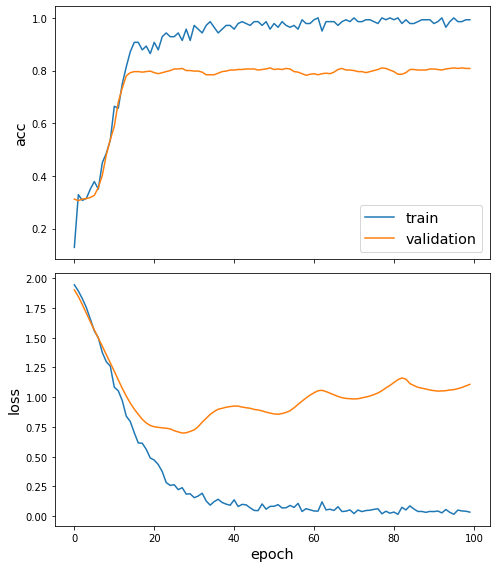

In [20]:
sg.utils.plot_history(history)

As the final part of our evaluation, let's check the model against the test set. We again create the data required for this using the `flow` method on our `FullBatchNodeGenerator` from above, and can use the model's `evaluate` method to compute the metric values for the trained model.

As expected, the model performs similarly on the validation set during training and on the test set here.

In [21]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [22]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 55ms/step - loss: 0.8534 - acc: 0.7935

Test Set Metrics:
	loss: 0.8534
	acc: 0.7935


In [23]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

1/1 [==============================] - 0s 149ms/step


These predictions will be the output of the softmax layer, so to get final categories we'll use the `inverse_transform` method of our target attribute specification to turn these values back to the original categories.

In [24]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [25]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
31336,Neural_Networks,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Neural_Networks,Probabilistic_Methods
1107140,Case_Based,Theory
1102850,Neural_Networks,Neural_Networks
31349,Neural_Networks,Neural_Networks
1106418,Theory,Theory


## **Reference**



- https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gcn-node-classification.html